0. Install required libraries

In [2]:
# install if needed
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 85.5 MB/s eta 0:00:00


1. Import libraries

In [3]:
import pennylane as qml
from pennylane import numpy as np        # autograd-enabled numpy (use this inside circuit & loss)
import numpy as onp                     # plain numpy for dataset / random indices


In [4]:
# sklearn for data + evaluation
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report

2. Dataset Preprocessing

In [5]:
# ---------------------------
# 1) Dataset & preprocessing
# ---------------------------
iris = load_iris()
X_onp = iris.data                     # shape (150, 4)
y_onp = iris.target.reshape(-1, 1)    # shape (150, 1)
print("shape of data and target:",X_onp.shape, y_onp.shape)
print("-------------First 5 sample data-----------------------")
print("5 sample data:\n",X_onp[:5])
print("5 sample target:\n",y_onp[:5])
print("-------------Last 5 sample data-----------------------")
print("5 sample data:\n",X_onp[-5:])
print("5 sample target:\n",y_onp[-5:])


shape of data and target: (150, 4) (150, 1)
-------------First 5 sample data-----------------------
5 sample data:
 [[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]
5 sample target:
 [[0]
 [0]
 [0]
 [0]
 [0]]
-------------Last 5 sample data-----------------------
5 sample data:
 [[6.7 3.  5.2 2.3]
 [6.3 2.5 5.  1.9]
 [6.5 3.  5.2 2. ]
 [6.2 3.4 5.4 2.3]
 [5.9 3.  5.1 1.8]]
5 sample target:
 [[2]
 [2]
 [2]
 [2]
 [2]]


In [6]:
# standardize the 4 features (important for sensible angle magnitudes)
scaler = StandardScaler()
X_onp = scaler.fit_transform(X_onp)
print("-------------Standardized data-----------------------")
print("5 sample data:\n",X_onp[:5])

print("-------------Last 5 sample data-----------------------")
print("5 sample data:\n",X_onp[-5:])


-------------Standardized data-----------------------
5 sample data:
 [[-0.90068117  1.01900435 -1.34022653 -1.3154443 ]
 [-1.14301691 -0.13197948 -1.34022653 -1.3154443 ]
 [-1.38535265  0.32841405 -1.39706395 -1.3154443 ]
 [-1.50652052  0.09821729 -1.2833891  -1.3154443 ]
 [-1.02184904  1.24920112 -1.34022653 -1.3154443 ]]
-------------Last 5 sample data-----------------------
5 sample data:
 [[ 1.03800476 -0.13197948  0.8195957   1.44883158]
 [ 0.55333328 -1.28296331  0.70592084  0.92230284]
 [ 0.79566902 -0.13197948  0.8195957   1.05393502]
 [ 0.4321654   0.78880759  0.93327055  1.44883158]
 [ 0.06866179 -0.13197948  0.76275827  0.79067065]]


In [7]:


# one-hot encode labels -- handle sklearn API changes across versions
try:
    encoder = OneHotEncoder(sparse_output=False)
except TypeError:
    encoder = OneHotEncoder(sparse=False)
Y_onp = encoder.fit_transform(y_onp)  # shape (150, 3)
print("------------- One hot Encoding followed by Standardized data-----------------------")
print("5 sample data:\n",Y_onp[:5])

print("-------------Last 5 sample data-----------------------")
print("5 sample data:\n",Y_onp[-5:])



------------- One hot Encoding followed by Standardized data-----------------------
5 sample data:
 [[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
-------------Last 5 sample data-----------------------
5 sample data:
 [[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [73]:

# train / val split (use onp arrays then convert to pennylane.numpy)
X_tr_onp, X_val_onp, Y_tr_onp, Y_val_onp = train_test_split(
    X_onp, Y_onp, test_size=0.30, random_state=42, stratify=y_onp
)

# convert to pennylane.numpy arrays for autograd compatibility
X_train = np.array(X_tr_onp)
X_val   = np.array(X_val_onp)
Y_train = np.array(Y_tr_onp)
Y_val   = np.array(Y_val_onp)
print("shape of train/val data:",X_train.shape, X_val.shape, Y_train.shape, Y_val.shape)
print("-------------train data-----------------------")
print("5 sample data:\n",X_train[:10])
print("5 sample target:\n",Y_train[:10])
print("-------------val data-----------------------")
print("5 sample data:\n",X_val[:10])
print("5 sample target:\n",Y_val[:10])

shape of train/val data: (105, 4) (45, 4) (105, 3) (45, 3)
-------------train data-----------------------
5 sample data:
 [[-0.90068117 -1.28296331 -0.4308277  -0.13075464]
 [ 0.4321654  -1.97355361  0.42173371  0.3957741 ]
 [-0.90068117  1.70959465 -1.2833891  -1.18381211]
 [ 1.15917263  0.32841405  1.21745768  1.44883158]
 [-0.17367395 -0.59237301  0.194384    0.13250973]
 [ 1.03800476 -0.13197948  0.8195957   1.44883158]
 [-1.14301691  0.09821729 -1.2833891  -1.44707648]
 [-0.90068117  1.70959465 -1.22655167 -1.3154443 ]
 [-1.74885626 -0.36217625 -1.34022653 -1.3154443 ]
 [ 1.52267624 -0.13197948  1.21745768  1.18556721]]
5 sample target:
 [[0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]
-------------val data-----------------------
5 sample data:
 [[ 1.76501198 -0.36217625  1.44480739  0.79067065]
 [ 0.31099753 -0.36217625  0.53540856  0.26414192]
 [ 0.55333328 -0.59237301  0.76275827  0.3957741 ]
 [ 0.55333328 

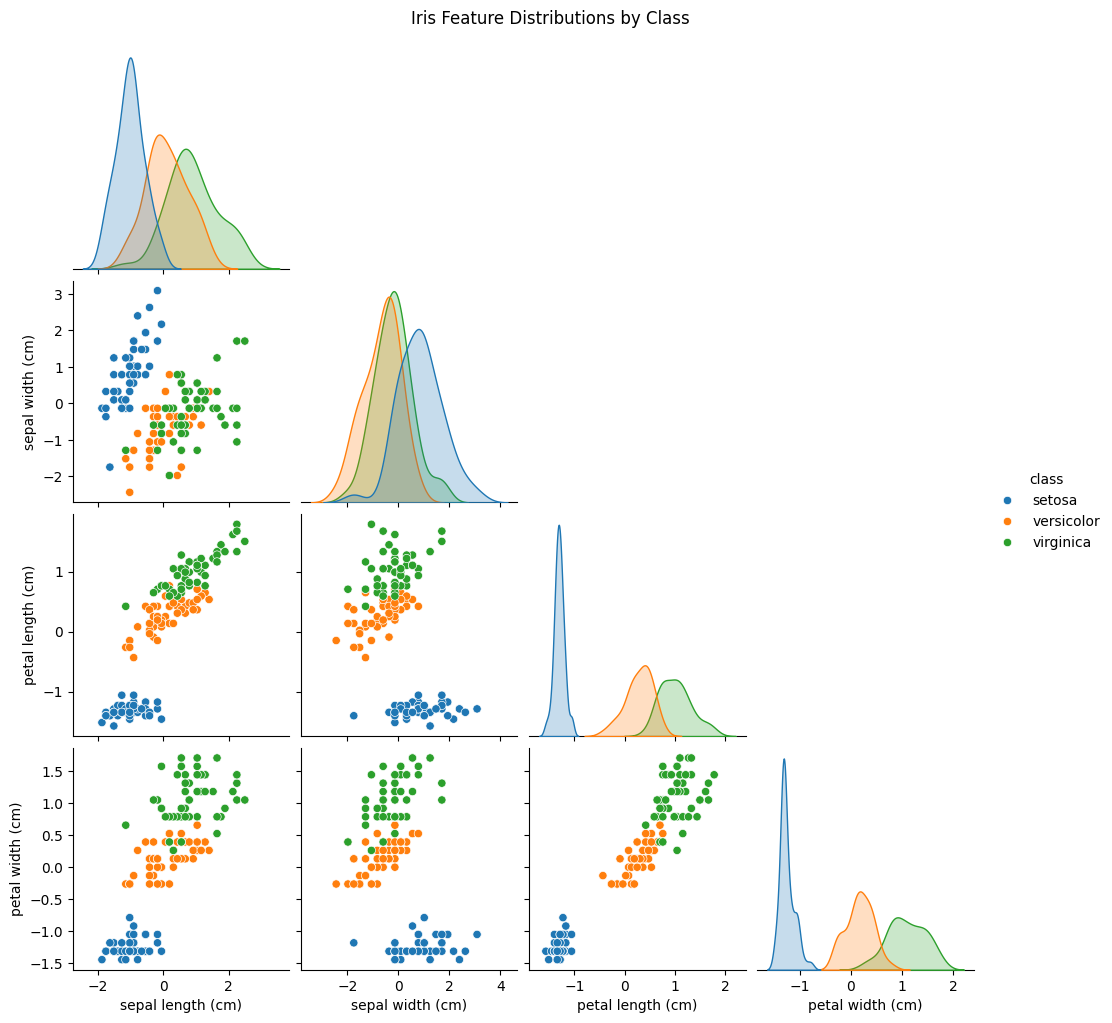

/tmp/ipython-input-1796049791.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='class', data=df, palette='Set2')


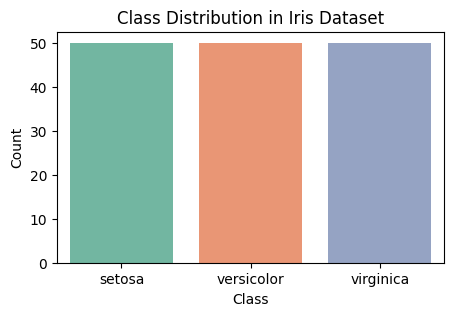

In [74]:
# ---------------------------
# Visualization: Data Distribution
# ---------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a DataFrame for easy plotting
df = pd.DataFrame(X_onp, columns=iris.feature_names)
df['class'] = [iris.target_names[i] for i in y_onp.flatten()]

# Pairplot: feature distributions per class
sns.pairplot(df, hue='class', diag_kind='kde', corner=True)
plt.suptitle("Iris Feature Distributions by Class", y=1.02)
plt.show()

# Class count bar chart
plt.figure(figsize=(5, 3))
sns.countplot(x='class', data=df, palette='Set2')
plt.title("Class Distribution in Iris Dataset")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

Experiment - 1


In [91]:

# ---------------------------
# 2) Quantum device & circuit
# ---------------------------
num_qubits = 4
num_classes = 3
dev = qml.device("default.qubit", wires=num_qubits)

# Angle encoding (one rotation per qubit based on feature value)
def angle_encoding(x):
    # x is a length-4 pennylane.numpy array (ArrayBox during differentiation)
    # --- Base features ---
    for i in range(num_qubits):
        qml.RY(x[i], wires=i)
    # entanglement: chain + closing gate
    for i in range(num_qubits - 1):
        qml.CNOT(wires=[i, i + 1])
    # close the ring
    qml.CNOT(wires=[num_qubits - 1, 0])






# Single hidden layer: Rot gates (three parameters per qubit) + entanglement
def single_hidden_layer(weights):
    # weights shape: (num_qubits, 3)
    for wire in range(num_qubits):
        qml.Rot(weights[wire, 0], weights[wire, 1], weights[wire, 2], wires=wire)
    # entanglement: chain + closing gate
    for i in range(num_qubits - 1):
        qml.CNOT(wires=[i, i + 1])
    # close the ring
    qml.CNOT(wires=[num_qubits - 1, 0])



# QNode: angle encode -> single hidden layer -> measure Z on all qubits
@qml.qnode(dev, interface="autograd")
def circuit(weights, x):
    angle_encoding(x)
    single_hidden_layer(weights)

    # return expectation values from all 4 qubits
    return [qml.expval(qml.PauliZ(i)) for i in range(num_classes)]


In [92]:

# ---------------------------
# initialize parameters (a bit larger scale)
# ---------------------------
np.random.seed(42)
weights = np.random.randn(num_qubits, 3, requires_grad=True)    # (4,3) hidden-layer Rot params


print("weights shape:",weights.shape)

print("weights:\n",weights)


weights shape: (4, 3)
weights:
 [[ 0.49671415 -0.1382643   0.64768854]
 [ 1.52302986 -0.23415337 -0.23413696]
 [ 1.57921282  0.76743473 -0.46947439]
 [ 0.54256004 -0.46341769 -0.46572975]]


In [93]:
print(qml.draw(circuit)(weights, X_onp))

0: ──RY(M0)─╭●───────╭X──Rot(0.50,-0.14,0.65)──╭●───────╭X─┤  <Z>
1: ──RY(M1)─╰X─╭●────│───Rot(1.52,-0.23,-0.23)─╰X─╭●────│──┤  <Z>
2: ──RY(M2)────╰X─╭●─│───Rot(1.58,0.77,-0.47)─────╰X─╭●─│──┤  <Z>
3: ──RY(M3)───────╰X─╰●──Rot(0.54,-0.46,-0.47)───────╰X─╰●─┤     

M0 = 
[-0.90068117  1.01900435 -1.34022653 -1.3154443 ]
M1 = 
[-1.14301691 -0.13197948 -1.34022653 -1.3154443 ]
M2 = 
[-1.38535265  0.32841405 -1.39706395 -1.3154443 ]
M3 = 
[-1.50652052  0.09821729 -1.2833891  -1.3154443 ]


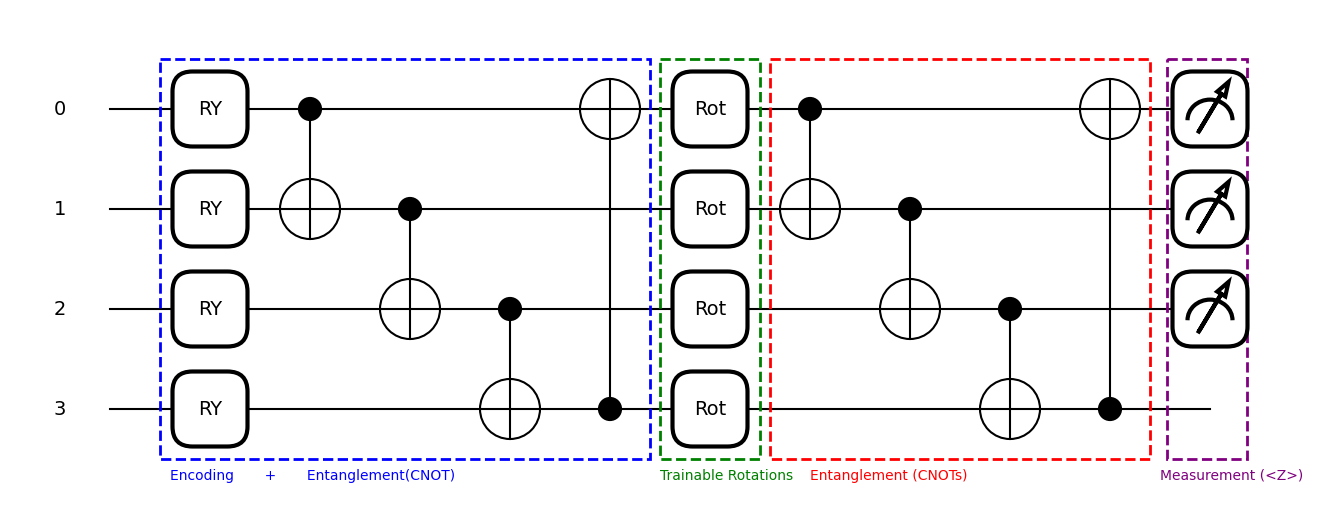

In [94]:
import matplotlib.pyplot as plt
# --- Draw ---
fig, ax = qml.draw_mpl(circuit)(weights, X_onp)

# Highlight encoding
ax.add_patch(plt.Rectangle((-0.5, -0.5), 4.9, num_qubits,
                           fill=False, color="blue", lw=2, linestyle="--"))
ax.text(-0.4, num_qubits - 0.3, "Encoding       +       Entanglement(CNOT)", color="blue", fontsize=10)

# Highlight variational rotation
ax.add_patch(plt.Rectangle((4.5, -0.5), 1.0, num_qubits,
                           fill=False, color="green", lw=2, linestyle="--"))
ax.text(4.5, num_qubits - 0.3, "Trainable Rotations", color="green", fontsize=10)

# Highlight entanglement
ax.add_patch(plt.Rectangle((5.6, -0.5), 3.8, num_qubits,
                           fill=False, color="red", lw=2, linestyle="--"))
ax.text(6, num_qubits - 0.3, "Entanglement (CNOTs)", color="red", fontsize=10)

# Measurement region
ax.add_patch(plt.Rectangle((9.57, -0.5), 0.8, num_qubits,
                           fill=False, color="purple", lw=2, linestyle="--"))
ax.text(9.5, num_qubits - 0.3, "Measurement (<Z>)", color="purple", fontsize=10)

plt.show()

In [95]:
# ---------------------------
# Changes: Cross-entropy +  Adam + tuning
# ---------------------------
from pennylane.optimize import AdamOptimizer   # switch optimizer



In [96]:
# Post-measurement non-linearity: softmax
def softmax(logits):
    exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

# Loss
def cross_entropy(pred_probs, true_onehot):
    eps = 1e-9
    return -np.mean(np.sum(true_onehot * np.log(pred_probs + eps), axis=1))

# Variational classifier
def variational_classifier(weights, x):
    return circuit(weights, x)

def cost(weights, X, Y):
    logits = np.array([variational_classifier(weights, x) for x in X])
    probs = softmax(logits)
    return cross_entropy(probs, Y)

# Prediction helper
def predict_dataset(weights, X):
    return np.array([variational_classifier(weights, x) for x in X])
def cost(weights, X, Y):
    logits = np.array([variational_classifier(weights, x) for x in X])
    probs = softmax(logits)
    return cross_entropy(probs, Y)

# Prediction helper
def predict_dataset(weights, X):
    return np.array([variational_classifier(weights, x) for x in X])

In [97]:


opt = AdamOptimizer(stepsize=0.1)   # try 0.01 (tune if needed)
# ---------------------------
# Training loop (tune epochs/batch size)
# ---------------------------
epochs = 100
batch_size = 8
n_train = X_train.shape[0]
# Training loop
for it in range(1, epochs + 1):
    batch_idx = onp.random.randint(0, n_train, size=(batch_size,))
    X_batch = X_train[batch_idx]
    Y_batch = Y_train[batch_idx]

    weights = opt.step(lambda w: cost(w, X_batch, Y_batch), weights)

    #    if it % 10 == 0 or it == 1:
    train_logits = predict_dataset(weights, X_train)
    val_logits   = predict_dataset(weights, X_val)
    train_preds = onp.argmax(onp.array(softmax(train_logits)), axis=1)
    val_preds = onp.argmax(onp.array(softmax(val_logits)), axis=1)
    train_acc = onp.mean(train_preds == onp.argmax(onp.array(Y_train), axis=1))
    val_acc = onp.mean(val_preds == onp.argmax(onp.array(Y_val), axis=1))
    train_loss = float(cost(weights, X_train, Y_train))
    val_loss   = float(cost(weights, X_val, Y_val))
    print(f"Iter {it:4d} | Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f} | Train acc: {train_acc:.4f} | Val acc: {val_acc:.4f}")

Iter    1 | Train loss: 1.0096 | Val loss: 1.0261 | Train acc: 0.4952 | Val acc: 0.4222
Iter    2 | Train loss: 1.0009 | Val loss: 1.0170 | Train acc: 0.5143 | Val acc: 0.4222
Iter    3 | Train loss: 0.9924 | Val loss: 1.0092 | Train acc: 0.5143 | Val acc: 0.4667
Iter    4 | Train loss: 0.9839 | Val loss: 1.0018 | Train acc: 0.5333 | Val acc: 0.4889
Iter    5 | Train loss: 0.9761 | Val loss: 0.9955 | Train acc: 0.5810 | Val acc: 0.5111
Iter    6 | Train loss: 0.9687 | Val loss: 0.9899 | Train acc: 0.7048 | Val acc: 0.5556
Iter    7 | Train loss: 0.9633 | Val loss: 0.9858 | Train acc: 0.7429 | Val acc: 0.6667
Iter    8 | Train loss: 0.9596 | Val loss: 0.9836 | Train acc: 0.7714 | Val acc: 0.6667
Iter    9 | Train loss: 0.9581 | Val loss: 0.9831 | Train acc: 0.7429 | Val acc: 0.6889
Iter   10 | Train loss: 0.9555 | Val loss: 0.9812 | Train acc: 0.7524 | Val acc: 0.6667
Iter   11 | Train loss: 0.9523 | Val loss: 0.9789 | Train acc: 0.7429 | Val acc: 0.6667
Iter   12 | Train loss: 0.9471 |

In [83]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

# ---------------------------
# Final evaluation (test set)
# ---------------------------

# Get predictions directly from circuit
test_logits = predict_dataset(weights, X_val)  # logits shape (n, 3)

# Convert to plain numpy for sklearn
test_logits_onp = onp.array(test_logits)
Y_test_onp = onp.array(Y_val)

# Convert logits -> class predictions
test_pred_classes = onp.argmax(test_logits_onp, axis=1)
test_true_classes = onp.argmax(Y_test_onp, axis=1)

# Column stack predicted and true classes
test_compare = onp.column_stack((test_pred_classes, test_true_classes))
df_compare = pd.DataFrame(
    test_compare,
    columns=["Predicted", "True"]
)

# Add a column to indicate match/mismatch
df_compare["Match"] = df_compare["Predicted"] == df_compare["True"]

print(df_compare)

print("\nConfusion Matrix (test):")
print(confusion_matrix(test_true_classes, test_pred_classes))

print("\nClassification Report (test):")
print(classification_report(test_true_classes, test_pred_classes, digits=4))


    Predicted  True  Match
0           2     2   True
1           1     1   True
2           2     2   True
3           1     1   True
4           1     2  False
5           2     2   True
6           1     1   True
7           1     1   True
8           0     0   True
9           2     2   True
10          0     0   True
11          0     0   True
12          2     2   True
13          2     2   True
14          0     0   True
15          2     2   True
16          0     1  False
17          0     0   True
18          0     0   True
19          0     0   True
20          1     1   True
21          0     0   True
22          1     1   True
23          2     2   True
24          1     2  False
25          1     1   True
26          0     1  False
27          0     1  False
28          1     1   True
29          0     0   True
30          1     2  False
31          2     2   True
32          1     1   True
33          0     0   True
34          2     2   True
35          0     0   True
3